Initial shape: (230055, 74)
After column selection: (230055, 23)
After dropping empty columns: (230055, 23)
Columns with missing values:
 emp_length          8967
revol_util           215
delinq_2yrs           30
inq_last_6mths        30
open_acc              30
pub_rec               30
total_acc             30
earliest_cr_line      30
annual_inc             4
purpose                1
addr_state             1
dti                    1
revol_bal              1
dtype: int64


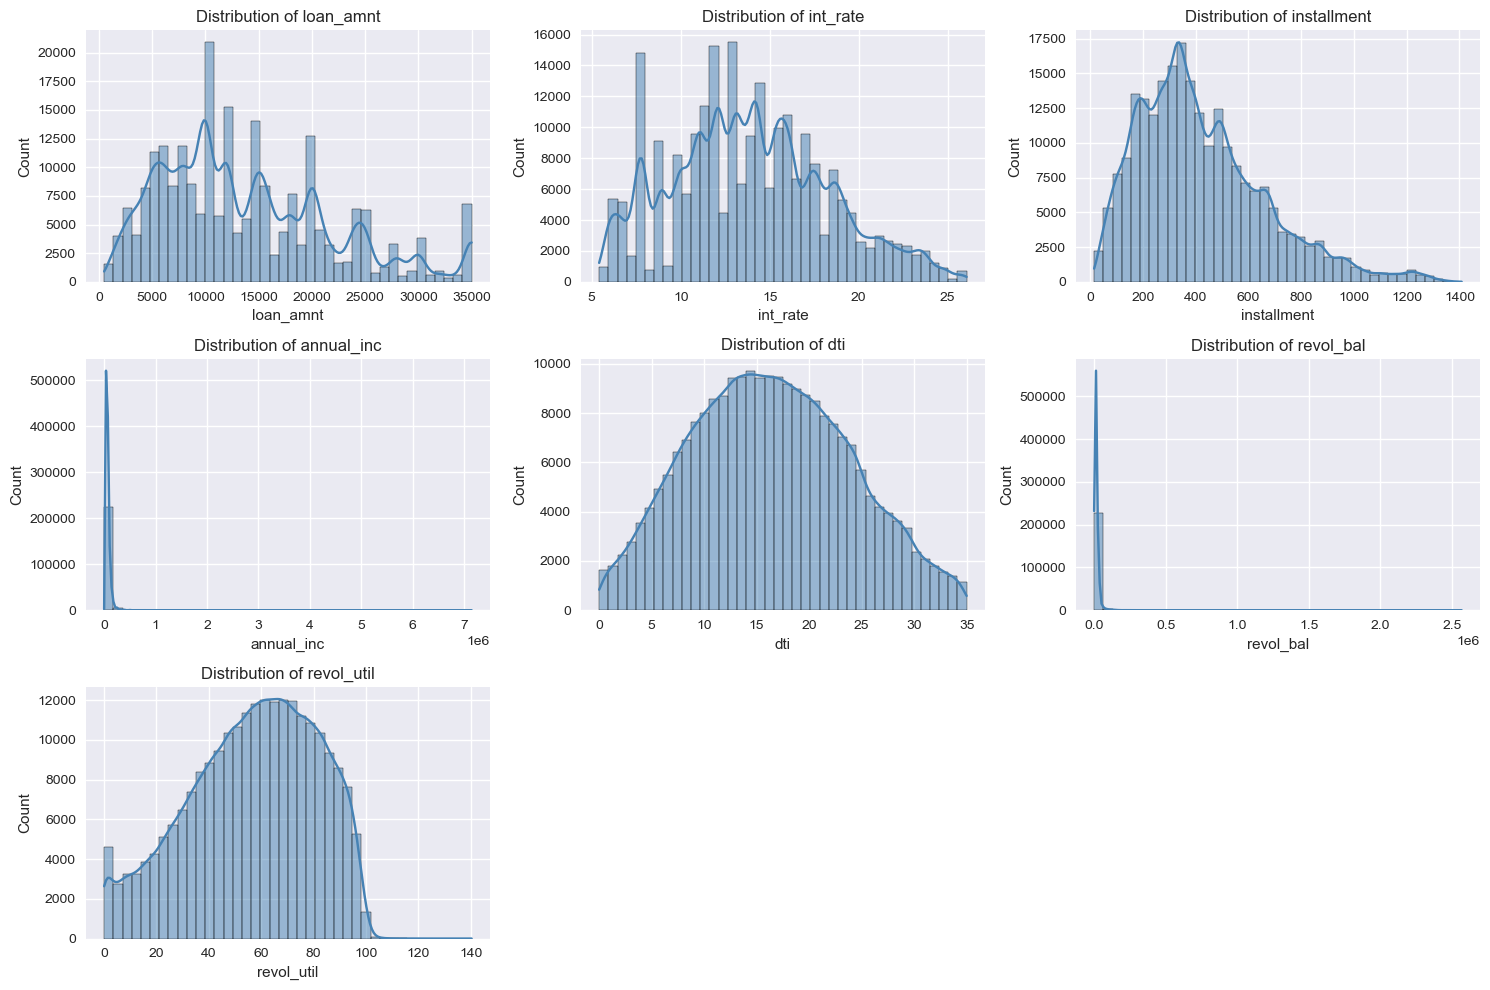

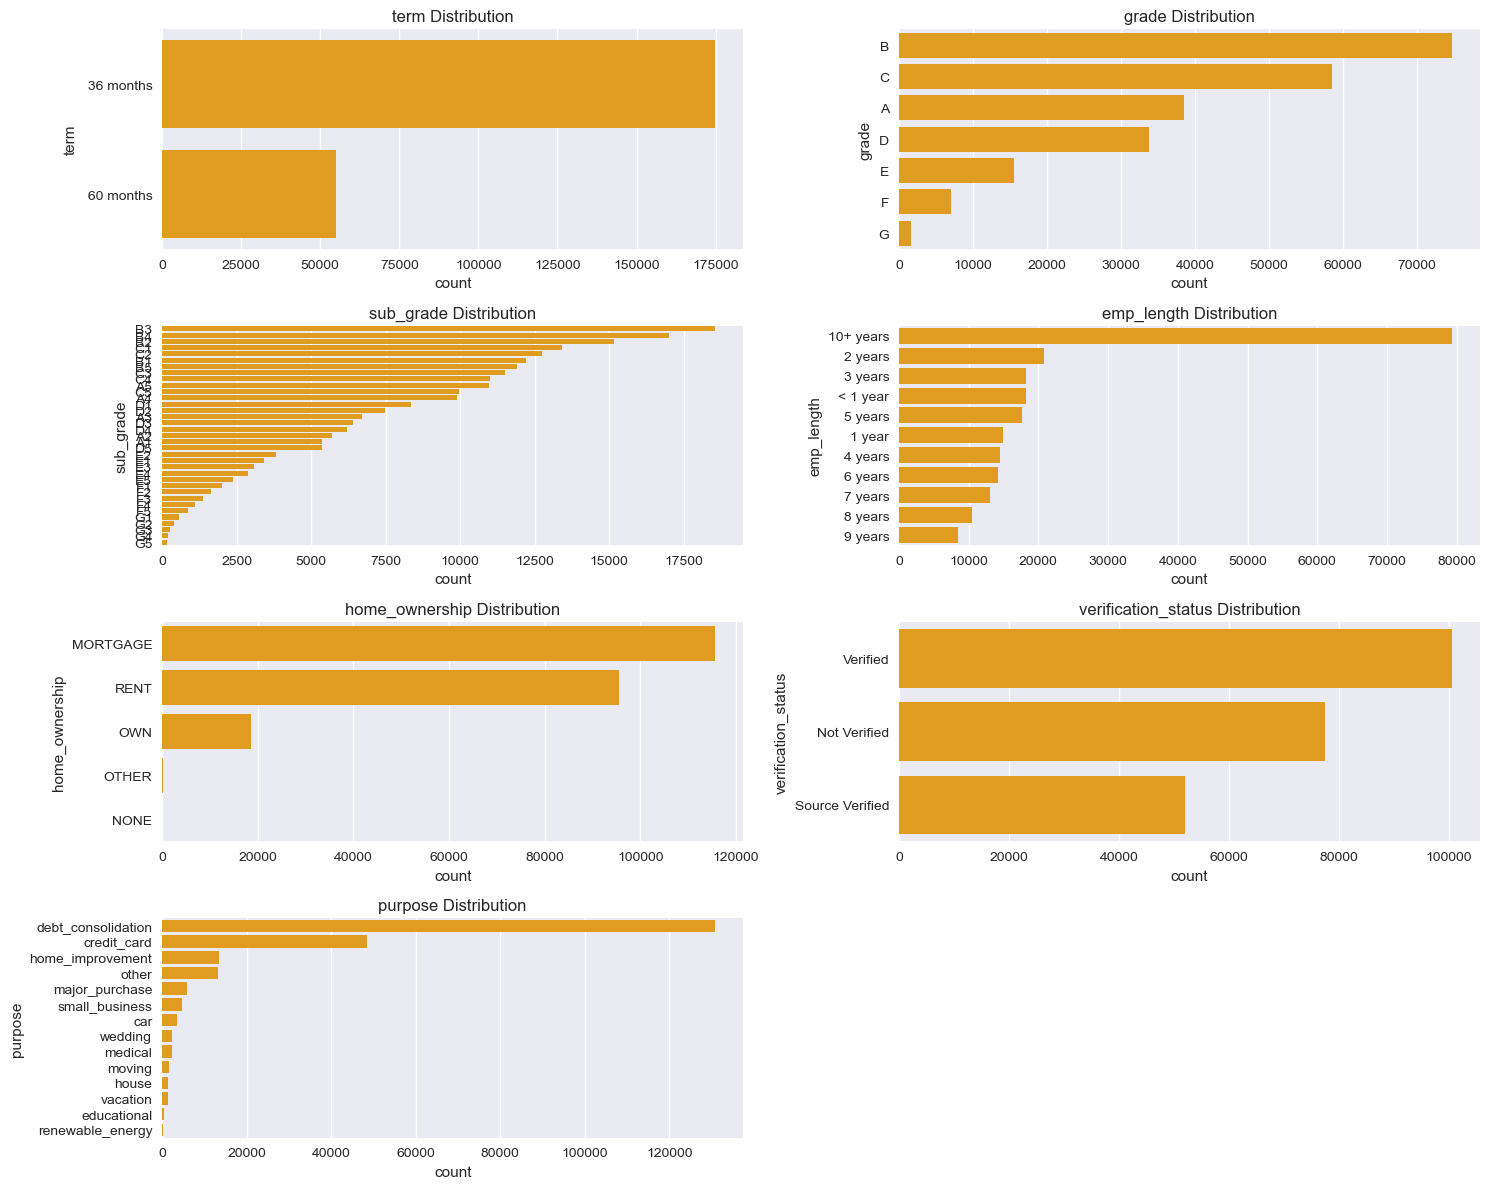

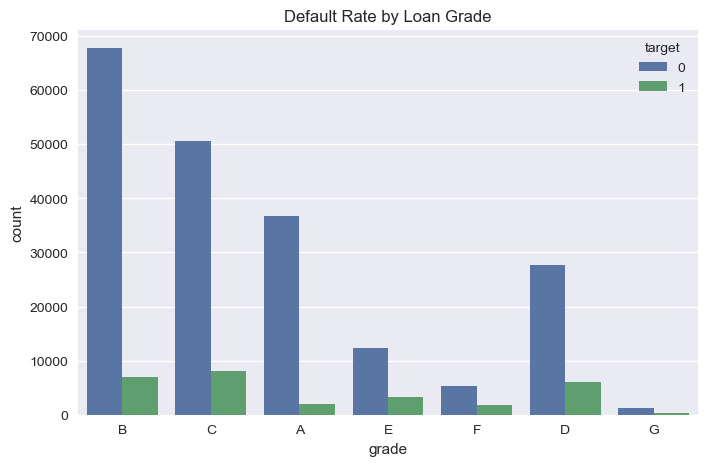

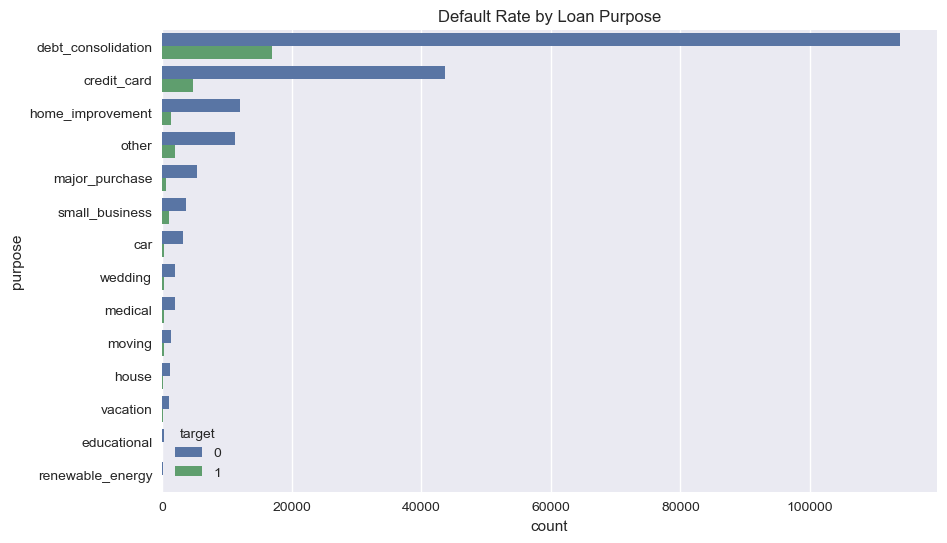

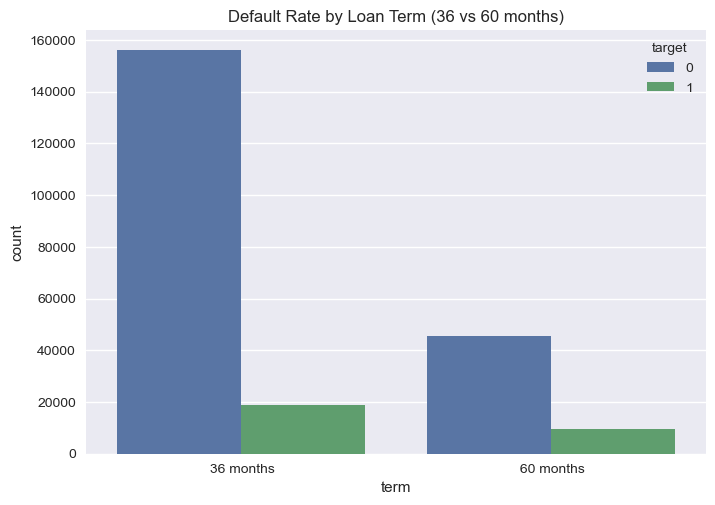

/var/folders/3f/br0vdpqs7f1bcy46rf8z78n80000gn/T/ipykernel_16552/3240619762.py:109: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='int_rate', hue='target', data=loan, shade=True)


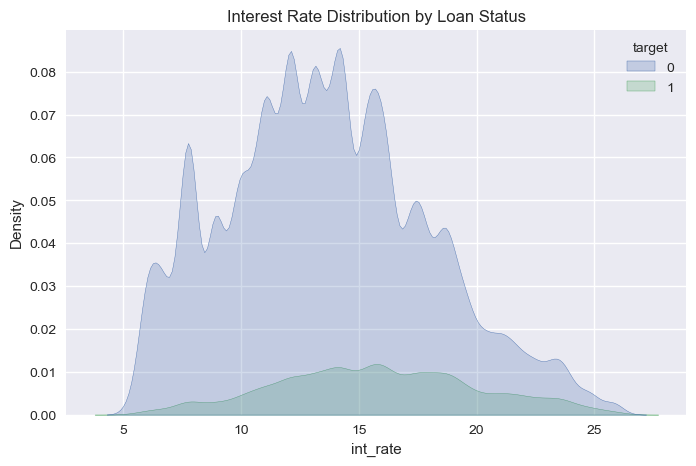

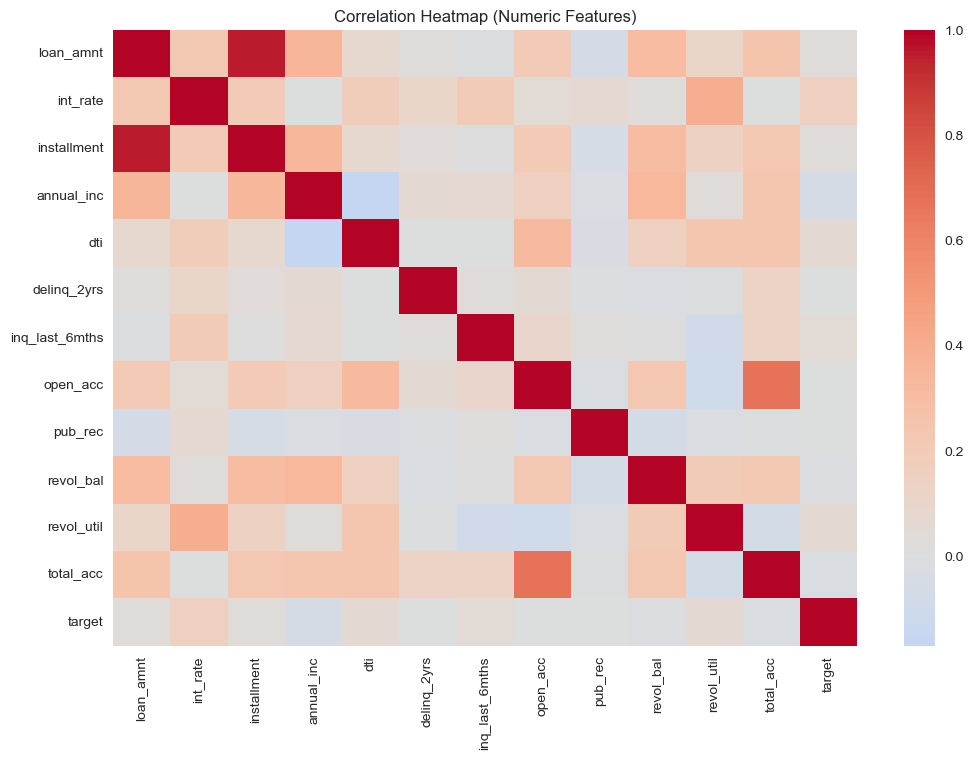

target            1.000000
int_rate          0.162208
revol_util        0.059365
dti               0.057586
inq_last_6mths    0.045933
loan_amnt         0.024382
installment       0.018650
delinq_2yrs       0.000400
open_acc         -0.000265
pub_rec          -0.000767
Name: target, dtype: float64


In [1]:
# ----------------------------------------------------------
# 1. IMPORT LIBRARIES & LOAD DATA
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# Load the dataset
loan = pd.read_csv("/Users/santhoshrajs/Documents/trim 5/APA/loan_Team3.csv")
print("Initial shape:", loan.shape)

# ----------------------------------------------------------
# 2. SELECT RELEVANT VARIABLES FOR ANALYSIS
# ----------------------------------------------------------
cols_to_keep = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'issue_d',
    'purpose', 'addr_state', 'dti', 'delinq_2yrs',
    'inq_last_6mths', 'open_acc', 'pub_rec',
    'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_line',
    'loan_status'
]

loan = loan[cols_to_keep]
print("After column selection:", loan.shape)

# ----------------------------------------------------------
# 3. REMOVE COMPLETELY EMPTY COLUMNS
# ----------------------------------------------------------
loan = loan.dropna(axis=1, how='all')
print("After dropping empty columns:", loan.shape)

# ----------------------------------------------------------
# 4. CHECK MISSING VALUE SUMMARY
# ----------------------------------------------------------
missing = loan.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)

# ----------------------------------------------------------
# 5. HANDLE MISSING VALUES (ONLY FOR RELEVANT COLUMNS)
# ----------------------------------------------------------
# Fill numeric missing with median
num_cols = loan.select_dtypes(include=['float64', 'int64']).columns
loan[num_cols] = loan[num_cols].apply(lambda x: x.fillna(x.median()))

# Fill categorical missing with mode
cat_cols = loan.select_dtypes(include='object').columns
loan[cat_cols] = loan[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

# ----------------------------------------------------------
# 6. CREATE TARGET VARIABLE (Default = 1, Non-default = 0)
# ----------------------------------------------------------
loan['target'] = loan['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0
)

# ----------------------------------------------------------
# 7. EDA ONLY FOR NON-EMPTY, RELEVANT VARIABLES
# ----------------------------------------------------------
# Univariate: Numerical variables
num_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util']

plt.figure(figsize=(15,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(loan[col], bins=40, kde=True, color='steelblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Categorical EDA
cat_features = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']
plt.figure(figsize=(15,12))
for i, col in enumerate(cat_features, 1):
    plt.subplot(4, 2, i)
    sns.countplot(y=col, data=loan, order=loan[col].value_counts().index, color='orange')
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 8. BIVARIATE ANALYSIS (Feature vs Target)
# ----------------------------------------------------------
# Grade vs Default
plt.figure(figsize=(8,5))
sns.countplot(x='grade', hue='target', data=loan)
plt.title("Default Rate by Loan Grade")
plt.show()

# Purpose vs Default
plt.figure(figsize=(10,6))
sns.countplot(y='purpose', hue='target', data=loan, order=loan['purpose'].value_counts().index)
plt.title("Default Rate by Loan Purpose")
plt.show()

# Term vs Default
sns.countplot(x='term', hue='target', data=loan)
plt.title("Default Rate by Loan Term (36 vs 60 months)")
plt.show()

# Interest Rate vs Default
plt.figure(figsize=(8,5))
sns.kdeplot(x='int_rate', hue='target', data=loan, shade=True)
plt.title("Interest Rate Distribution by Loan Status")
plt.show()

# ----------------------------------------------------------
# 9. CORRELATION MATRIX
# ----------------------------------------------------------
plt.figure(figsize=(12,8))
corr = loan.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Check correlation with target
print(corr['target'].sort_values(ascending=False).head(10))


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ----------------------------------------------------------
# 1️⃣ EMPLOYMENT LENGTH (convert text → numeric)
# ----------------------------------------------------------
def clean_emp_length(val):
    if pd.isnull(val): 
        return np.nan
    if '<' in val:
        return 0
    if '10+' in val:
        return 10
    return int(''.join(filter(str.isdigit, val)))

loan['emp_length_num'] = loan['emp_length'].apply(clean_emp_length)
print("\n🔹 emp_length_num (after conversion):")
print(loan['emp_length_num'].describe())
print(loan['emp_length_num'].head(10))

# ----------------------------------------------------------
# 2️⃣ TERM (convert from ' 36 months' → 36)
# ----------------------------------------------------------
loan['term_num'] = loan['term'].str.extract(r'(\d+)').astype(int)
print("\n🔹 term_num (numeric form of term):")
print(loan['term_num'].value_counts())

# ----------------------------------------------------------
# 3️⃣ ISSUE DATE (extract year, month)
# ----------------------------------------------------------
# Specify format explicitly to avoid warnings
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%Y', errors='coerce')
loan['issue_year'] = loan['issue_d'].dt.year
loan['issue_month'] = loan['issue_d'].dt.month

print("\n🔹 issue_year sample:")
print(loan['issue_year'].value_counts().head())
print("\n🔹 issue_month sample:")
print(loan['issue_month'].value_counts().head())

# ----------------------------------------------------------
# 4️⃣ CREDIT AGE (in months)
# ----------------------------------------------------------
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'], format='%b-%Y', errors='coerce')

# Compute difference in months manually using year & month difference
loan['credit_age_months'] = (
    (loan['issue_d'].dt.year - loan['earliest_cr_line'].dt.year) * 12 +
    (loan['issue_d'].dt.month - loan['earliest_cr_line'].dt.month)
)
loan['credit_age_months'] = loan['credit_age_months'].fillna(loan['credit_age_months'].median())

print("\n🔹 credit_age_months (borrower credit history age in months):")
print(loan['credit_age_months'].describe())

# ----------------------------------------------------------
# 5️⃣ DERIVED FINANCIAL RATIOS
# ----------------------------------------------------------

# Loan-to-Income Ratio
loan['loan_to_income'] = loan['loan_amnt'] / loan['annual_inc']
print("\n🔹 loan_to_income (loan_amnt / annual_inc):")
print(loan['loan_to_income'].describe())

# Interest-to-Income Ratio
loan['interest_to_income'] = (loan['int_rate'] / 100) * loan['loan_amnt'] / loan['annual_inc']
print("\n🔹 interest_to_income ((int_rate * loan_amnt) / annual_inc):")
print(loan['interest_to_income'].describe())

# Installment Ratio
loan['installment_ratio'] = loan['installment'] / loan['loan_amnt']
print("\n🔹 installment_ratio (installment / loan_amnt):")
print(loan['installment_ratio'].describe())

# Revolving Balance-to-Income Ratio
loan['revol_balance_to_income'] = loan['revol_bal'] / loan['annual_inc']
print("\n🔹 revol_balance_to_income (revol_bal / annual_inc):")
print(loan['revol_balance_to_income'].describe())

# Replace infinities and NaNs with 0
loan.replace([np.inf, -np.inf], np.nan, inplace=True)
loan.fillna(0, inplace=True)

# ----------------------------------------------------------
# 6️⃣ ENCODE CATEGORICAL VARIABLES
# ----------------------------------------------------------
cat_cols = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
encoder = LabelEncoder()

for col in cat_cols:
    loan[col] = encoder.fit_transform(loan[col])
    print(f"\n🔹 Encoded '{col}': unique values -> {loan[col].nunique()}")
    print(loan[[col]].head(10))

# ----------------------------------------------------------
# 7️⃣ DROP NON-NUMERIC ORIGINALS (TEXT COLUMNS)
# ----------------------------------------------------------
loan.drop(columns=['emp_length', 'term', 'earliest_cr_line', 'issue_d', 'loan_status'], inplace=True, errors='ignore')

print("\n✅ Final Feature Set Ready for Modeling:")
print(loan.columns)
print("\nFinal dataset shape:", loan.shape)
loan.head(10)



🔹 emp_length_num (after conversion):
count    230055.000000
mean          6.034366
std           3.613990
min           0.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: emp_length_num, dtype: float64
0    10
1     0
2    10
3    10
4     1
5     3
6     8
7     9
8     4
9     0
Name: emp_length_num, dtype: int64

🔹 term_num (numeric form of term):
term_num
36    174962
60     55093
Name: count, dtype: int64

🔹 issue_year sample:
issue_year
2013    134755
2012     52765
2011     21721
2010     12537
2009      5281
Name: count, dtype: int64

🔹 issue_month sample:
issue_month
12    25771
11    25497
10    24558
9     22947
8     21822
Name: count, dtype: int64

🔹 credit_age_months (borrower credit history age in months):
count    230055.000000
mean        182.460825
std          84.809213
min           6.000000
25%         126.000000
50%         167.000000
75%         224.000000
max         785.000000
Name: credit_age_months, dty

,loan_amnt,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,target,emp_length_num,term_num,issue_year,issue_month,credit_age_months,loan_to_income,interest_to_income,installment_ratio,revol_balance_to_income
0,5000.0,10.65,162.87,1,6,4,24000.0,2,1,3,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,0,10,36,2011,12,323,0.208333,0.022187,0.032574,0.568667
1,2500.0,15.27,59.83,2,13,4,30000.0,1,0,10,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,1,0,60,2011,12,152,0.083333,0.012725,0.023932,0.056233
2,2400.0,15.96,84.33,2,14,4,12252.0,0,11,14,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,0,10,36,2011,12,121,0.195886,0.031263,0.035138,0.241267
3,10000.0,13.49,339.31,2,10,4,49200.0,1,9,4,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,0,10,36,2011,12,190,0.203252,0.027419,0.033931,0.113780
4,3000.0,12.69,67.79,1,9,4,80000.0,1,9,36,17.94,0.0,0.0,15.0,0.0,27783.0,53.9,38.0,0,1,60,2011,12,191,0.037500,0.004759,0.022597,0.347288
5,5000.0,7.90,156.46,0,3,4,36000.0,1,13,3,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0,0,3,36,2011,12,85,0.138889,0.010972,0.031292,0.221194
6,7000.0,15.96,170.08,2,14,4,47004.0,0,2,27,23.51,0.0,1.0,7.0,0.0,17726.0,85.6,11.0,0,8,60,2011,12,77,0.148923,0.023768,0.024297,0.377117
7,3000.0,18.64,109.43,4,20,4,48000.0,1,0,4,5.35,0.0,2.0,4.0,0.0,8221.0,87.5,4.0,0,9,36,2011,12,59,0.062500,0.011650,0.036477,0.171271
8,5600.0,21.28,152.39,5,26,3,40000.0,1,11,4,5.55,0.0,2.0,11.0,0.0,5210.0,32.6,13.0,1,4,60,2011,12,92,0.140000,0.029792,0.027212,0.130250
9,5375.0,12.69,121.45,1,9,4,15000.0,2,9,42,18.08,0.0,0.0,2.0,0.0,9279.0,36.5,3.0,1,0,60,2011,12,87,0.358333,0.045472,0.022595,0.618600


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Ensure the dataset is ready
print("Shape:", loan.shape)
print("Columns:", loan.columns)

# Define independent (X) and dependent (y) variables
X = loan.drop(columns=['target'])
y = loan['target']

# Add constant term for logistic regression intercept
X = sm.add_constant(X)

# Split into train and test (optional, just to check generalization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Shape: (230055, 28)
Columns: Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'target',
       'emp_length_num', 'term_num', 'issue_year', 'issue_month',
       'credit_age_months', 'loan_to_income', 'interest_to_income',
       'installment_ratio', 'revol_balance_to_income'],
      dtype='object')


In [9]:
# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Summary output
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.355872
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               161038
Model:                          Logit   Df Residuals:                   161010
Method:                           MLE   Df Model:                           27
Date:                Fri, 24 Oct 2025   Pseudo R-squ.:                 0.05377
Time:                        16:25:59   Log-Likelihood:                -57309.
converged:                       True   LL-Null:                       -60566.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     383.1206     19.185     19.969      0.000     345.518   

In [11]:
# Get odds ratios
odds_ratios = np.exp(result.params)
print("\n🔹 Odds Ratios (Impact on Default Probability):")
print(odds_ratios.sort_values(ascending=False))



🔹 Odds Ratios (Impact on Default Probability):
const                      2.438697e+166
loan_to_income              7.870664e+00
interest_to_income          4.526091e+00
revol_balance_to_income     1.214973e+00
int_rate                    1.203939e+00
inq_last_6mths              1.051864e+00
purpose                     1.033628e+00
home_ownership              1.022651e+00
open_acc                    1.010181e+00
dti                         1.007516e+00
emp_length_num              1.005740e+00
grade                       1.004297e+00
revol_util                  1.001721e+00
installment                 1.000727e+00
annual_inc                  9.999994e-01
revol_bal                   9.999957e-01
loan_amnt                   9.999600e-01
credit_age_months           9.996131e-01
term_num                    9.994526e-01
total_acc                   9.985957e-01
addr_state                  9.977956e-01
delinq_2yrs                 9.949121e-01
verification_status         9.933068e-01
pub_rec  

In [13]:
# Filter by p-value significance
significant_vars = result.pvalues[result.pvalues < 0.05]
print("\n✅ Significant Variables (p < 0.05):")
print(significant_vars)



✅ Significant Variables (p < 0.05):
const                      1.017597e-88
loan_amnt                  2.767859e-08
int_rate                   5.667209e-77
installment                1.171662e-03
sub_grade                  9.234916e-12
home_ownership             3.959593e-07
purpose                    5.204688e-30
addr_state                 2.408003e-05
dti                        1.466954e-09
inq_last_6mths             7.243323e-14
open_acc                   2.110961e-05
revol_bal                  2.341633e-04
revol_util                 2.190566e-05
emp_length_num             1.236146e-02
issue_year                 1.659153e-89
issue_month                1.005383e-43
credit_age_months          3.146108e-04
loan_to_income             2.173026e-14
installment_ratio          6.154778e-03
revol_balance_to_income    3.286996e-02
dtype: float64


/var/folders/3f/br0vdpqs7f1bcy46rf8z78n80000gn/T/ipykernel_16552/4184441509.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Variable', x='Coefficient', data=coef_df, palette='coolwarm')


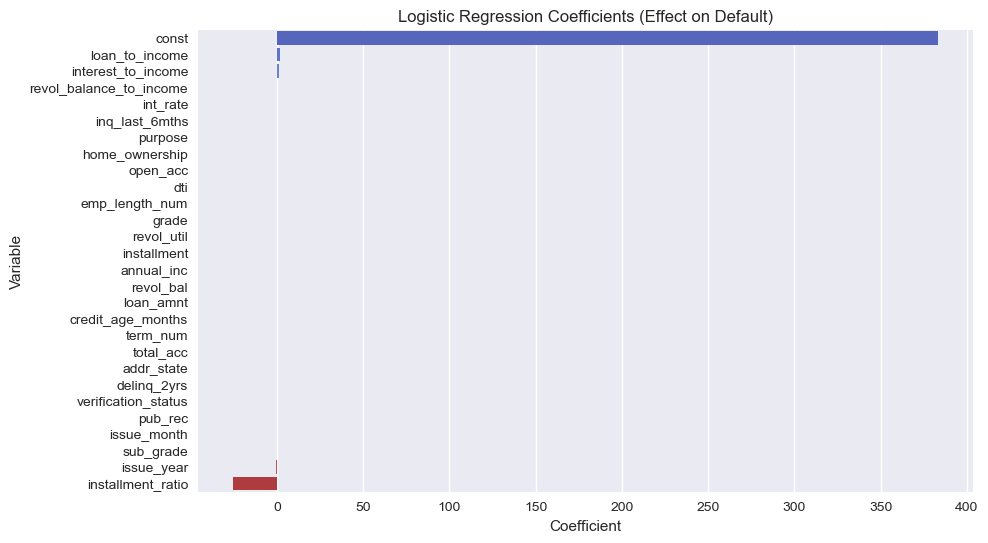

In [15]:
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Variable': result.params.index,
    'Coefficient': result.params.values,
    'P_Value': result.pvalues.values
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y='Variable', x='Coefficient', data=coef_df, palette='coolwarm')
plt.title("Logistic Regression Coefficients (Effect on Default)")
plt.show()


STEP 1: DATA PREPARATION

✅ Feature Matrix Shape: (230055, 27)
✅ Target Variable Shape: (230055,)

📊 Target Distribution:
target
0    201431
1     28624
Name: count, dtype: int64

📊 Default Rate: 12.44%

✅ Training Set Size: 161038 samples
✅ Test Set Size: 69017 samples

STEP 2: STATISTICAL SIGNIFICANCE ANALYSIS

🔄 Fitting logistic regression model...

📋 LOGISTIC REGRESSION SUMMARY:
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               161038
Model:                          Logit   Df Residuals:                   161010
Method:                           MLE   Df Model:                           27
Date:                Fri, 24 Oct 2025   Pseudo R-squ.:                 0.05201
Time:                        17:01:48   Log-Likelihood:                -57348.
converged:                       True   LL-Null:                       -60494.
Covariance Type:            nonrobust   LLR p-value:         

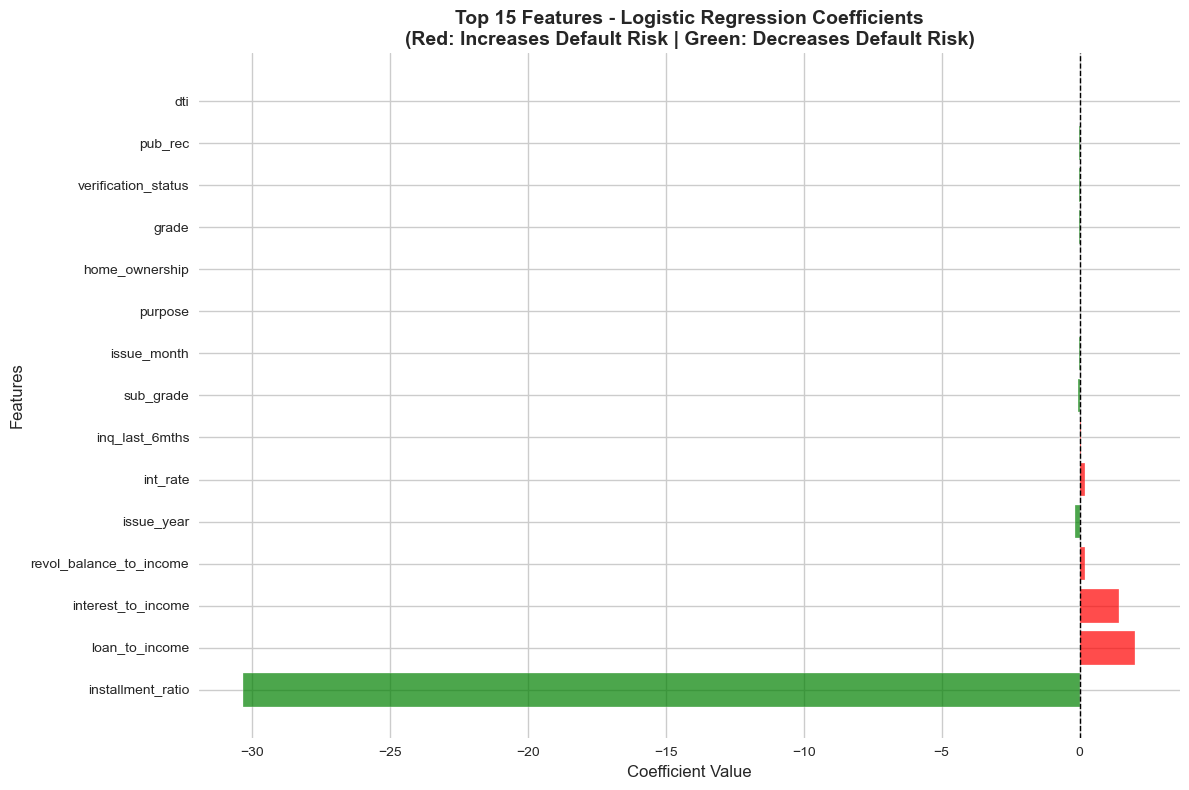

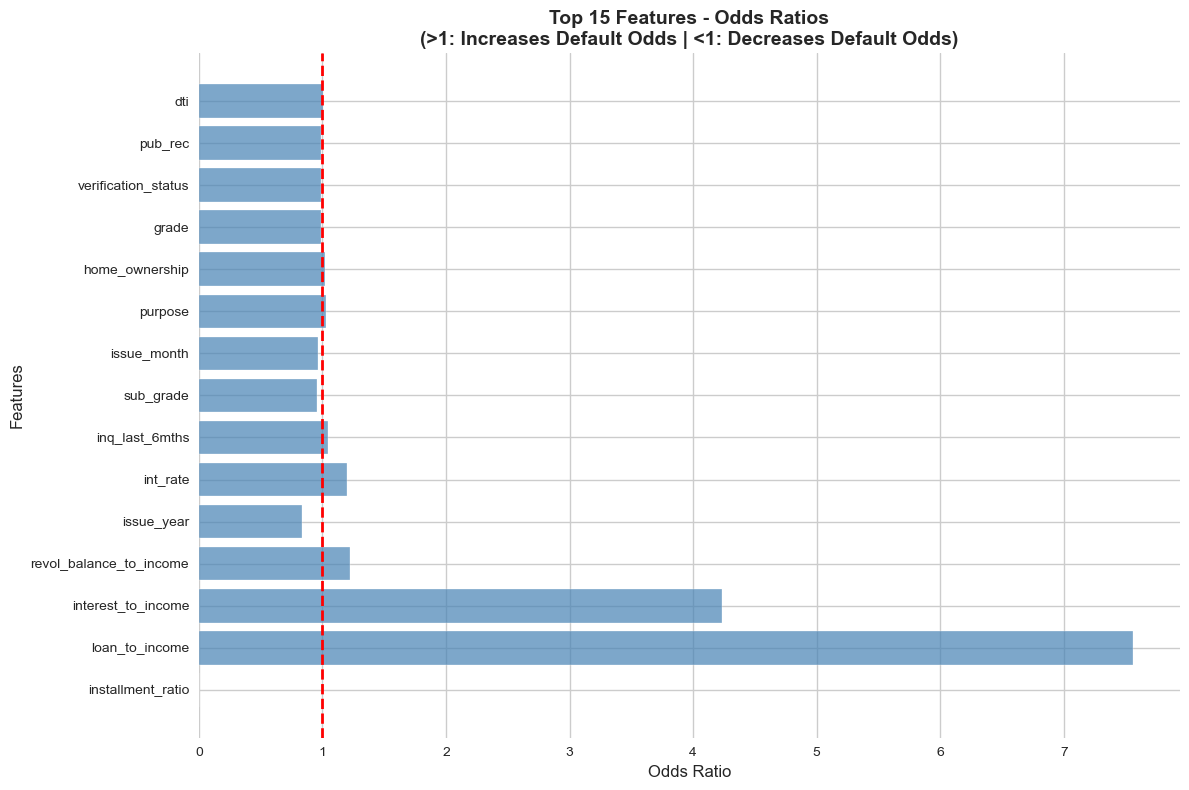


STEP 4: FEATURE SCALING
✅ Features scaled using StandardScaler

STEP 5: MODEL TRAINING & COMPARISON

🔹 Training Logistic Regression...
✅ Logistic Regression - ROC-AUC: 0.6774

🔹 Training Random Forest...
✅ Random Forest - ROC-AUC: 0.6865

🔹 Training XGBoost...
✅ XGBoost - ROC-AUC: 0.6967

STEP 6: MODEL PERFORMANCE COMPARISON

📊 MODEL COMPARISON TABLE:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.875552   0.000000 0.000000  0.000000 0.677388
      Random Forest  0.875581   0.000000 0.000000  0.000000 0.686490
            XGBoost  0.875494   0.392857 0.001281  0.002554 0.696686


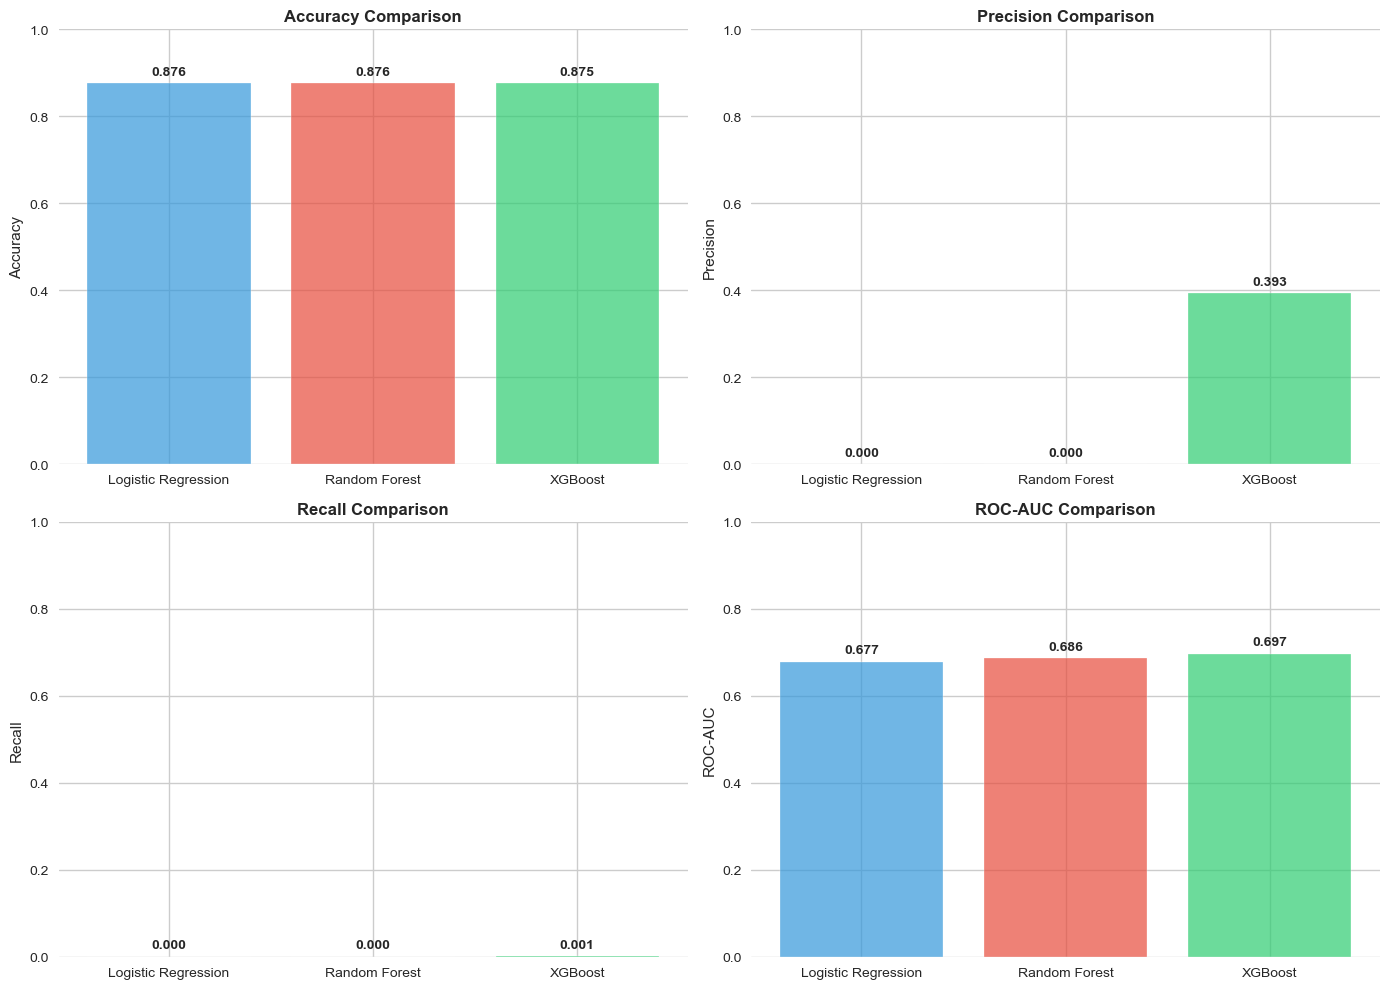


STEP 7: ROC CURVE ANALYSIS


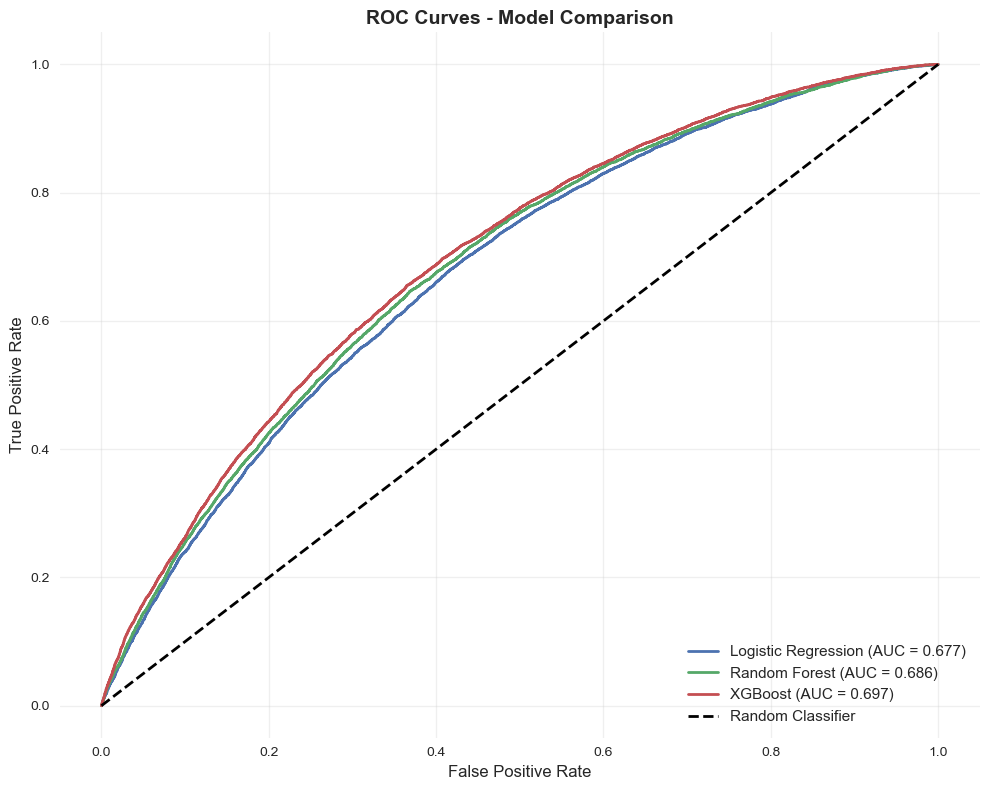


STEP 8: CONFUSION MATRICES


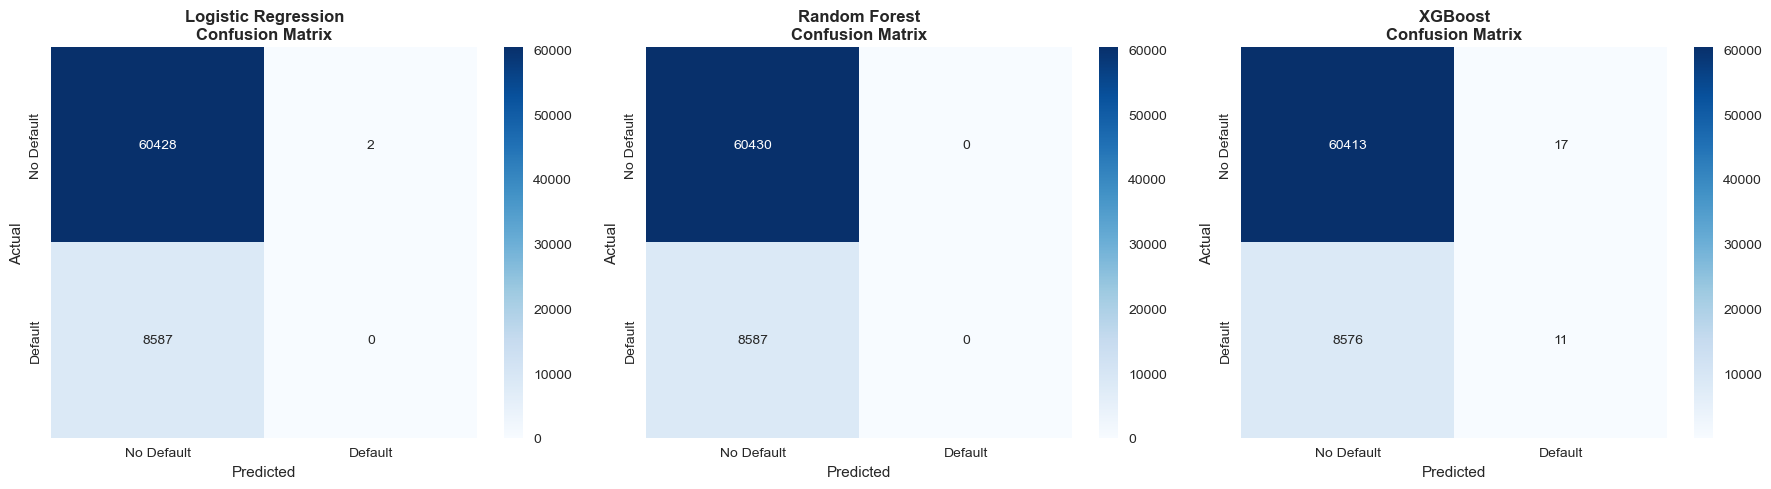


STEP 9: FEATURE IMPORTANCE FROM TREE MODELS


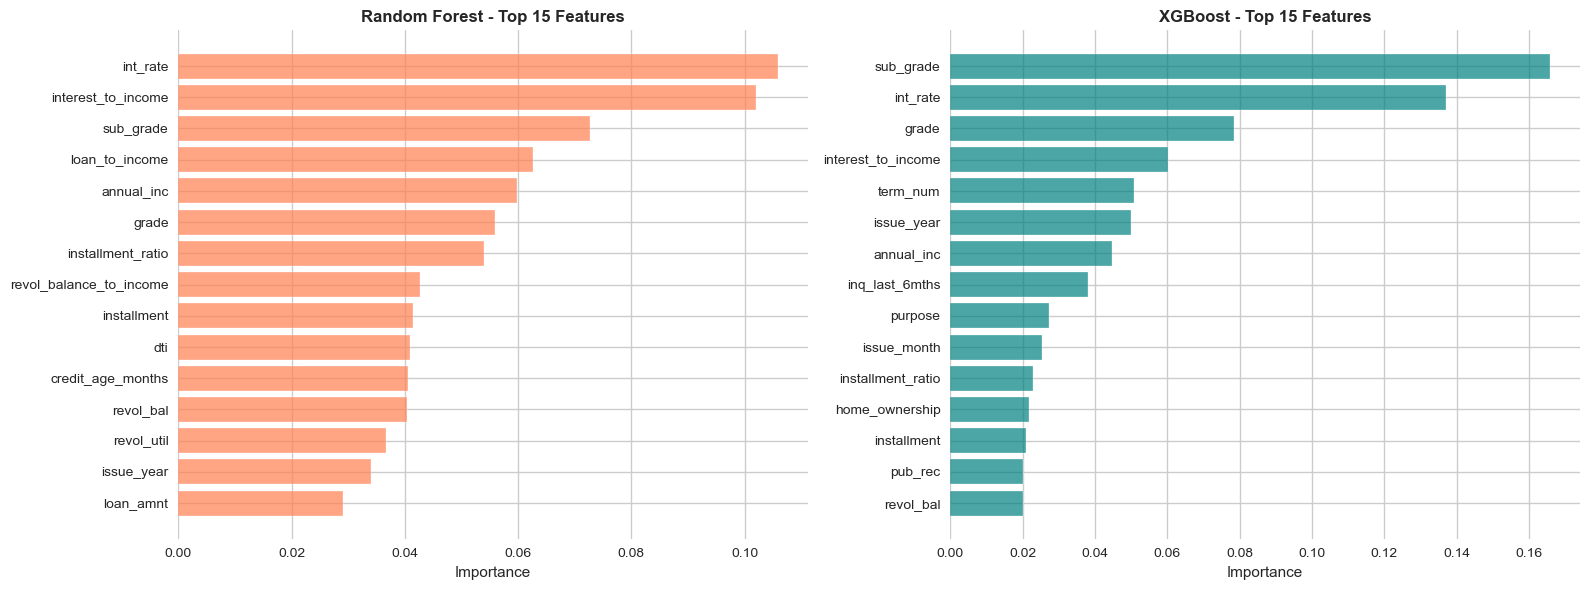


STEP 10: DETAILED CLASSIFICATION REPORTS

LOGISTIC REGRESSION - CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Default       0.88      1.00      0.93     60430
     Default       0.00      0.00      0.00      8587

    accuracy                           0.88     69017
   macro avg       0.44      0.50      0.47     69017
weighted avg       0.77      0.88      0.82     69017


RANDOM FOREST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Default       0.88      1.00      0.93     60430
     Default       0.00      0.00      0.00      8587

    accuracy                           0.88     69017
   macro avg       0.44      0.50      0.47     69017
weighted avg       0.77      0.88      0.82     69017


XGBOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Default       0.88      1.00      0.93     60430
     Default       0.39      0.00      0.00      8587

    accuracy           

In [17]:
# ============================================================
# LOAN DEFAULT PREDICTION - REGRESSION ANALYSIS & MODELING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# ============================================================
# STEP 1: PREPARE DATA FOR MODELING
# ============================================================
print("="*60)
print("STEP 1: DATA PREPARATION")
print("="*60)

# Separate features and target
X = loan.drop(columns=['target'])
y = loan['target']

print(f"\n✅ Feature Matrix Shape: {X.shape}")
print(f"✅ Target Variable Shape: {y.shape}")
print(f"\n📊 Target Distribution:")
print(y.value_counts())
print(f"\n📊 Default Rate: {y.mean()*100:.2f}%")

# Train-Test Split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✅ Training Set Size: {X_train.shape[0]} samples")
print(f"✅ Test Set Size: {X_test.shape[0]} samples")

# ============================================================
# STEP 2: STATISTICAL SIGNIFICANCE ANALYSIS (LOGISTIC REGRESSION)
# ============================================================
print("\n" + "="*60)
print("STEP 2: STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*60)

# Add constant for intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit statsmodels logistic regression
print("\n🔄 Fitting logistic regression model...")
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit(maxiter=100, disp=0)

print("\n📋 LOGISTIC REGRESSION SUMMARY:")
print(result.summary())

# Extract significant variables (p < 0.05)
print("\n" + "="*60)
print("STATISTICALLY SIGNIFICANT VARIABLES (p < 0.05)")
print("="*60)

significant_vars = result.pvalues[result.pvalues < 0.05].sort_values()
print(f"\nFound {len(significant_vars)} significant variables:\n")

sig_df = pd.DataFrame({
    'Variable': significant_vars.index,
    'P-Value': significant_vars.values,
    'Coefficient': result.params[significant_vars.index].values,
    'Odds Ratio': np.exp(result.params[significant_vars.index]).values
})

print(sig_df.to_string(index=False))

# ============================================================
# STEP 3: VISUALIZE FEATURE IMPORTANCE FROM COEFFICIENTS
# ============================================================
print("\n" + "="*60)
print("STEP 3: FEATURE IMPORTANCE VISUALIZATION")
print("="*60)

# Get top 15 features by absolute coefficient
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Abs_Coefficient': np.abs(result.params.values)
}).sort_values('Abs_Coefficient', ascending=False).head(16)

# Remove constant
coef_df = coef_df[coef_df['Feature'] != 'const']

plt.figure(figsize=(12, 8))
colors = ['red' if x > 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features - Logistic Regression Coefficients\n(Red: Increases Default Risk | Green: Decreases Default Risk)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# Odds Ratios Visualization
odds_df = coef_df.copy()
odds_df['Odds_Ratio'] = np.exp(odds_df['Coefficient'])

plt.figure(figsize=(12, 8))
plt.barh(odds_df['Feature'], odds_df['Odds_Ratio'], color='steelblue', alpha=0.7)
plt.xlabel('Odds Ratio', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features - Odds Ratios\n(>1: Increases Default Odds | <1: Decreases Default Odds)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 4: FEATURE SCALING
# ============================================================
print("\n" + "="*60)
print("STEP 4: FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")

# ============================================================
# STEP 5: MODEL TRAINING & EVALUATION
# ============================================================
print("\n" + "="*60)
print("STEP 5: MODEL TRAINING & COMPARISON")
print("="*60)

# Dictionary to store results
results = {}

# -------------------- Model 1: Logistic Regression --------------------
print("\n🔹 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_pred_proba,
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba)
}

print(f"✅ Logistic Regression - ROC-AUC: {results['Logistic Regression']['roc_auc']:.4f}")

# -------------------- Model 2: Random Forest --------------------
print("\n🔹 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # RF doesn't require scaling

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_pred_proba)
}

print(f"✅ Random Forest - ROC-AUC: {results['Random Forest']['roc_auc']:.4f}")

# -------------------- Model 3: XGBoost --------------------
print("\n🔹 Training XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                         random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    'model': xgb_model,
    'predictions': xgb_pred,
    'probabilities': xgb_pred_proba,
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb_pred_proba)
}

print(f"✅ XGBoost - ROC-AUC: {results['XGBoost']['roc_auc']:.4f}")

# ============================================================
# STEP 6: MODEL COMPARISON
# ============================================================
print("\n" + "="*60)
print("STEP 6: MODEL PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\n📊 MODEL COMPARISON TABLE:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(comparison_df['Model'], comparison_df[metric], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================
# STEP 7: ROC CURVES
# ============================================================
print("\n" + "="*60)
print("STEP 7: ROC CURVE ANALYSIS")
print("="*60)

plt.figure(figsize=(10, 8))

for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['probabilities'])
    auc = results[model_name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: CONFUSION MATRICES
# ============================================================
print("\n" + "="*60)
print("STEP 8: CONFUSION MATRICES")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(results.keys()):
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================
# STEP 9: FEATURE IMPORTANCE (RANDOM FOREST & XGBOOST)
# ============================================================
print("\n" + "="*60)
print("STEP 9: FEATURE IMPORTANCE FROM TREE MODELS")
print("="*60)

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='coral', alpha=0.7)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='teal', alpha=0.7)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ============================================================
# STEP 10: CLASSIFICATION REPORTS
# ============================================================
print("\n" + "="*60)
print("STEP 10: DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name in results.keys():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} - CLASSIFICATION REPORT")
    print('='*60)
    print(classification_report(y_test, results[model_name]['predictions'],
                                target_names=['No Default', 'Default']))

# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "="*60)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*60)

best_model = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
best_auc = comparison_df['ROC-AUC'].max()

print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
print(f"   - ROC-AUC Score: {best_auc:.4f}")
print(f"\n📌 KEY FINDINGS:")
print(f"   1. Total samples analyzed: {len(y)}")
print(f"   2. Default rate in dataset: {y.mean()*100:.2f}%")
print(f"   3. Number of significant predictors: {len(significant_vars)}")
print(f"   4. Best model achieves {best_auc:.2%} ROC-AUC on test data")

print("\n✅ ANALYSIS COMPLETE!")
print("="*60)

<Figure size 1000x800 with 0 Axes>

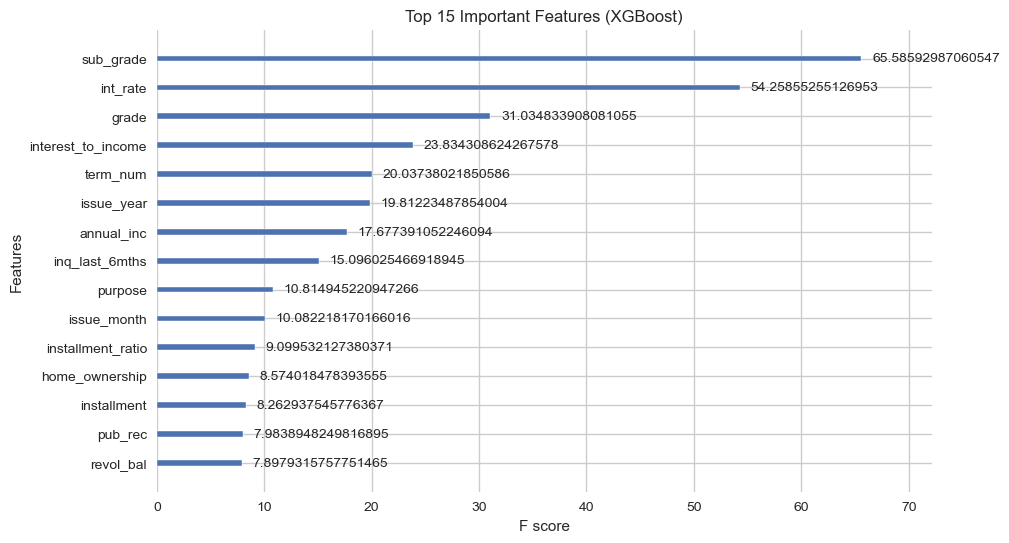

In [22]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.title("Top 15 Important Features (XGBoost)")
plt.show()


In [24]:
loan['default_prob'] = xgb_model.predict_proba(X)[:, 1]

# Segment borrowers by predicted default risk
loan['risk_segment'] = pd.cut(
    loan['default_prob'],
    bins=[0, 0.4, 0.8, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

loan['risk_segment'].value_counts(normalize=True)


risk_segment
Low Risk       0.995766
Medium Risk    0.004229
High Risk      0.000004
Name: proportion, dtype: float64

In [26]:
# Adjust cutoff for risk classification
loan['risk_segment'] = pd.cut(
    loan['default_prob'],
    bins=[0, 0.2, 0.5, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

loan['risk_segment'].value_counts(normalize=True)


risk_segment
Low Risk       0.846298
Medium Risk    0.153042
High Risk      0.000661
Name: proportion, dtype: float64

In [32]:
# ============================================================
# STEP: Add Default Probability and Risk Segments for Customers
# ============================================================

import pandas as pd
import numpy as np

# ✅ Assuming your trained XGBoost model and feature matrix X are already available
# Example:
# from xgboost import XGBClassifier
# xgb_model = XGBClassifier().fit(X_train, y_train)

# 1️⃣ Generate default probabilities for each customer
loan['default_prob'] = xgb_model.predict_proba(X)[:, 1]

# 2️⃣ Define updated probability bins for segmentation
bins = [0, 0.2, 0.5, 1.0]
labels = ['Low Risk', 'Medium Risk', 'High Risk']

# 3️⃣ Assign each borrower a risk category based on predicted probability
loan['risk_segment'] = pd.cut(
    loan['default_prob'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 4️⃣ Check segment distribution
segment_distribution = loan['risk_segment'].value_counts(normalize=True).rename('proportion')
print("\n📊 Risk Segment Distribution (Proportion of Total):\n")
print(segment_distribution)

# 5️⃣ Show sample data
print("\n📄 Sample of Customers with Default Probability & Risk Segment:\n")
print(loan[['default_prob', 'risk_segment']].head(10))

# 6️⃣ Save updated dataset as a CSV file
output_path = "loan_with_risk_segments_updated.csv"
loan.to_csv(output_path, index=False)

print(f"\n✅ File saved successfully as: {'/Users/santhoshrajs/Documents/trim 5/APA'}")




📊 Risk Segment Distribution (Proportion of Total):

risk_segment
Low Risk       0.846298
Medium Risk    0.153042
High Risk      0.000661
Name: proportion, dtype: float64

📄 Sample of Customers with Default Probability & Risk Segment:

   default_prob risk_segment
0      0.131803     Low Risk
1      0.455016  Medium Risk
2      0.281463  Medium Risk
3      0.166786     Low Risk
4      0.156711     Low Risk
5      0.105817     Low Risk
6      0.227586  Medium Risk
7      0.171667     Low Risk
8      0.359309  Medium Risk
9      0.276665  Medium Risk

✅ File saved successfully as: /Users/santhoshrajs/Documents/trim 5/APA
